In [1]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

import depth_estimation
from depth_estimation.depth_anything.dpt import DepthAnything

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the root of the project
root_path = Path('/home/artem-trybushenko/Projects/depth-estimation/')

weights_path_dict = {
    'vits': root_path / 'tmp/model-weights/depth_anything_v2_vits.pth',
    'vitb': root_path / 'tmp/model-weights/depth_anything_v2_vitb.pth',
    'vitl': root_path / 'tmp/model-weights/depth_anything_v2_vitl.pth',
}

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': (48, 96, 192, 384)},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': (96, 192, 384, 768)},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': (256, 512, 1024, 1024)},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': (1536, 1536, 1536, 1536)}
}

data_path = root_path.parents[1] / 'Data/1--Handshaking'

xFormers not available
xFormers not available


In [ ]:
# def load_depth_anything_v2_model(weights_path: Path, model_configs: dict, model_type: str = 'vits', device: str = 'cuda') -> DepthAnything:
#     model = DepthAnything(
#         encoder=model_configs[model_type]['encoder'],
#         features=model_configs[model_type]['features'],
#         out_channels=model_configs[model_type]['out_channels']
#     )
#     state_dict = torch.load(weights_path, map_location='cpu', weights_only=True)
#     model.load_state_dict(state_dict, strict=True)
#     model.eval()
#     model = model.to(device)
#     return model

# model_type = 'vits'
# model = load_depth_anything_v2_model(weights_path_dict[model_type], model_configs, model_type, device)

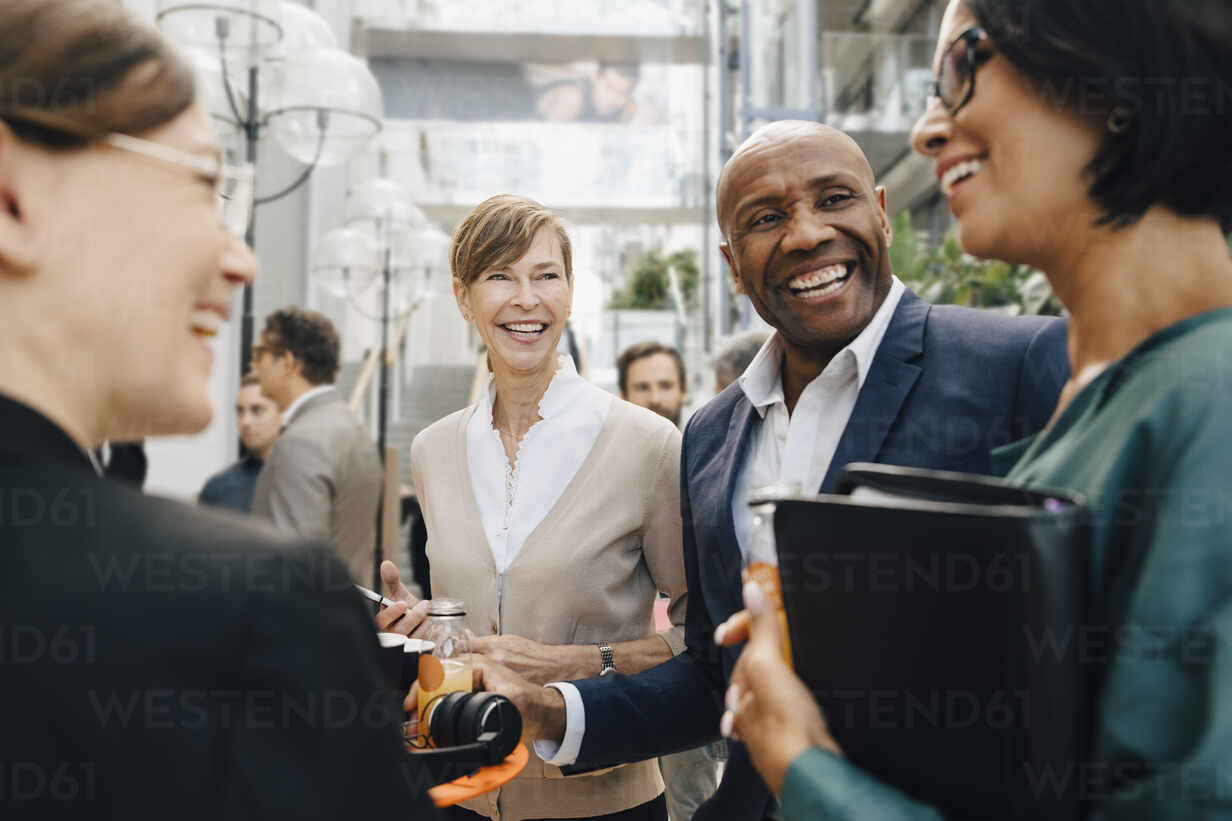

In [14]:
# @torch.no_grad()
# def make_prediction_depth_anything_v2(model, image, device):
#     processed_image, processed_shape = model.image2tensor(image)
#     processed_image = processed_image.to(device)
#     prediction = model(processed_image)
#     return prediction

# def plot_depth_heatmap(depth_map, original_shape):
#     depth_map_resized = torch.nn.functional.interpolate(depth_map.unsqueeze(0), size=original_shape, mode='bilinear', align_corners=False)
#     plt.imshow(depth_map_resized.squeeze().cpu().numpy(), cmap='viridis')
#     plt.colorbar()
#     plt.show()

image = Image.open(np.random.choice(list(data_path.glob('*.jpg')))).convert('RGB')
display(image)
# depth_map = make_prediction_depth_anything_v2(model, np.array(image), device)
# plot_depth_heatmap(depth_map, image.size[::-1])

In [15]:
from depth_estimation.estimation_model import DepthModel

model = DepthModel('v2_vits', 'cuda', '/home/artem-trybushenko/Projects/depth-estimation/tmp/model-weights', grayscale=False)

In [16]:
Image.fromarray(model.infer([np.array(image)])[0]).save(root_path / 'tmp/2024-11-25-spatial-bot-test/depth.png')

In [17]:
# depth_map
output_path = root_path / 'tmp/2024-11-25-spatial-bot-test/depth.png'
# depth_map_resized = torch.nn.functional.interpolate(depth_map.unsqueeze(0), size=image.size[::-1], mode='bilinear', align_corners=False)
# depth_map_image = Image.fromarray((depth_map_resized.squeeze().cpu().numpy() * 255 / depth_map_resized.max().item()).astype(np.uint8))
# depth_map_image.save(output_path)

In [18]:
image.save(output_path.parent / 'rgb.jpg')

In [6]:
from PIL import Image
import numpy as np
np.array(Image.open('/home/artem-trybushenko/Projects/depth-estimation/tmp/2024-11-16-images-to-inference/D519_264_066_0004_600.jpg').convert('RGB')).shape

(338, 600, 3)